# (N)on-(E)uclidean (U)pgrading
---
#### Description of NEU:
The NEU meta-algorithm learns a geometry for the input and (input $\times$ output) spaces by deforming them with a universal class of homeomorphisms + robustifies the involved loss functions to improve generalizability of the new and very flexible model.  
$$
\begin{aligned}
f \mapsto& \, \rho \circ f \circ \phi\\
\mathbb{E}_{\mathbb{P}}[\ell(f(X))] \mapsto & \,\max_{\mathbb{Q}\sim \mathbb{P}}\, \mathbb{E}_{\mathbb{Q}}[\ell(\rho(\phi(X), f\circ \phi(X)))].
\end{aligned}
$$
$\rho=\pi\circ \tilde{\rho}$, and $\tilde{\rho}$ and $\phi$ are "universal homeomorphisms" on $\operatorname{dom}(f)$ and on $\operatorname{dom}(f)\times \operatorname{co-dom}(f)$, respectively.  

---

---

#### Description of regression problem: 
In this notebook we implement the regression problem
$$
\begin{aligned}
y_i =&  \,f(x_i)\delta_i + \epsilon_i, \qquad i=1,\dots,N\\
\epsilon_i \sim &\, \mathcal{N}(0,\sigma),\\
\delta_i\sim &  \,U(1-D,1+D),
\end{aligned}
$$
for some *variance* $\sigma>0$ and *degree of model misspecification level* $0<D<1$.  
The quantity $\epsilon$ can be understood as, classical, additive noise while the quantity $\delta$ represents multiplicative noise.

---

---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
#---------------------------------#
# General Formatting Parameter(s) #
#---------------------------------#
d = 1 # Dimension of X
D = 1 # Dimension of Y

#------------------------------------#
# Training/Optimization Parameter(s) #
#------------------------------------#
# Robustness Parameter
robustness_parameter = .1
# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 600

#---------------------------#
# Architecture Parameter(s) #
#---------------------------#
# 1) Base Model
#---------------#
Initial_Depth = 2
Initial_Height = 50
# 2) Feature Map
#---------------#
Feature_map_depth = 40
Feature_map_height = 5
# 3) Readout Map
#---------------#
# Reconfiguration Parameters
N_Reconfigurations = 50
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 30
Height_per_reconfig = 5

#-------------------#
# Data Parameter(s) #
#-------------------#
# Test-set meta-parameters
Train_step_proportion = .5 # (i.e.: ratio of train to test-set sizes)
Extrapolation_size = .25 # (i.e.: size of test-train set domain (diameter/2))
# Train Data meta-parameters
N_data = 10**3 # (i.e.: N)
# Noise Parameters
noise_level = .5 # (i.e.: ε_i)
Distortion = .7 # (i.e.: δ_i)
# Unknown Function:
def unknown_f(x):
    return .1*x + .1*(x**4) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) + np.cos(7*(x**2))+ (x % .5)

### Run External/Auxiliary Notebooks

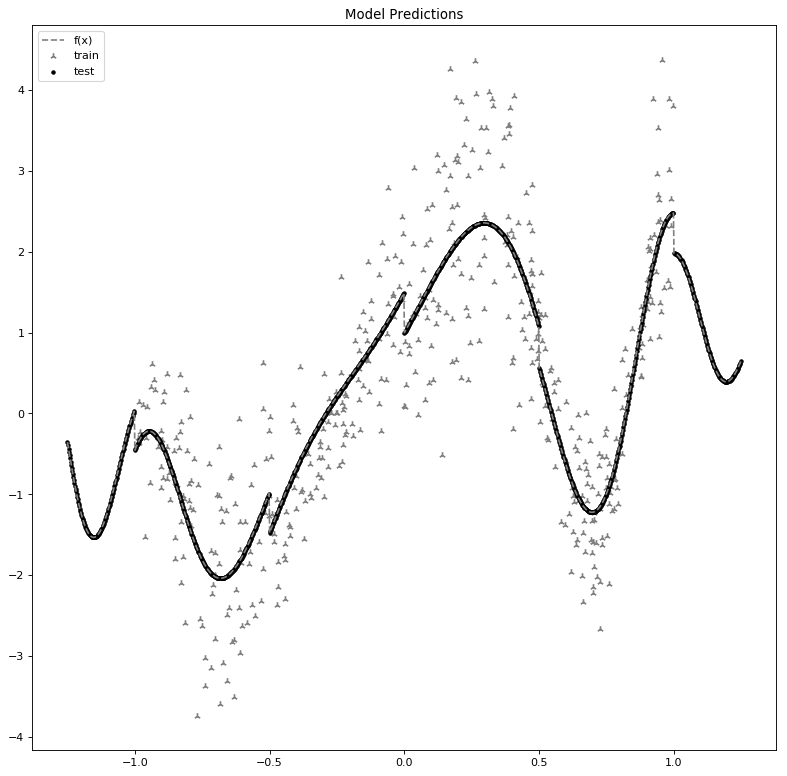

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=Full_Epochs,
                                                height=(N_Reconfigurations*Height_per_reconfig),
                                                depth=Initial_Depth,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Benchmark model - already exists: Loading...
Benchmark model - already exists: Loaded.


## 1+2) Get base regression model for NEU + Learn optimal feature map

In [6]:
if False:#os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=Full_Epochs, 
                                             height=Initial_Height, 
                                             depth=Initial_Depth,
                                             feature_map_depth=Feature_map_depth,
                                             feature_map_height=Feature_map_height,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/600
16/16 - 0s - loss: 0.7289 - mse: 1.2534 - mae: 0.6392 - mape: 109.5428
Epoch 2/600
16/16 - 0s - loss: 0.6399 - mse: 1.0139 - mae: 0.5670 - mape: 109.5592
Epoch 3/600
16/16 - 0s - loss: 0.6178 - mse: 0.9673 - mae: 0.5471 - mape: 114.0587
Epoch 4/600
16/16 - 0s - loss: 0.5985 - mse: 0.9014 - mae: 0.5337 - mape: 153.2633
Epoch 5/600
16/16 - 0s - loss: 0.6059 - mse: 0.9011 - mae: 0.5421 - mape: 171.8633
Epoch 6/600
16/16 - 0s - loss: 0.5758 - mse: 0.8295 - mae: 0.5165 - mape: 152.3679
Epoch 7/600
16/16 - 0s - loss: 0.5627 - mse: 0.7974 - mae: 0.5063 - mape: 137.0931
Epoch 8/600
16/16 - 0s - loss: 0.5342 - mse: 0.7279 - mae: 0.4829 - mape: 135.6581
Epoch 9/600
16/16 - 0s - loss: 0.5248 - mse: 0.7108 - mae: 0.4742 - mape: 121.4226
Epoch 10/600
16/16 - 0s - loss: 0.5203 - mse: 0.6976 - mae: 0.4700 - mape: 124.0549
Epoch 11/600
16/16 - 0s - loss: 0.5296 - mse: 0.7210 - mae: 0.4776 - mape: 144.6250
Epoch 12/600
16/16 - 0s - loss:

16/16 - 0s - loss: 0.3674 - mse: 0.3742 - mae: 0.3407 - mape: 142.6075
Epoch 99/600
16/16 - 0s - loss: 0.3618 - mse: 0.3610 - mae: 0.3362 - mape: 118.7576
Epoch 100/600
16/16 - 0s - loss: 0.3666 - mse: 0.3708 - mae: 0.3404 - mape: 131.2002
Epoch 101/600
16/16 - 0s - loss: 0.3721 - mse: 0.3843 - mae: 0.3446 - mape: 106.6453
Epoch 102/600
16/16 - 0s - loss: 0.3685 - mse: 0.3774 - mae: 0.3415 - mape: 137.6300
Epoch 103/600
16/16 - 0s - loss: 0.3649 - mse: 0.3734 - mae: 0.3381 - mape: 139.1907
Epoch 104/600
16/16 - 0s - loss: 0.3651 - mse: 0.3818 - mae: 0.3373 - mape: 133.3937
Epoch 105/600
16/16 - 0s - loss: 0.3615 - mse: 0.3654 - mae: 0.3355 - mape: 116.0158
Epoch 106/600
16/16 - 0s - loss: 0.3620 - mse: 0.3638 - mae: 0.3362 - mape: 117.1396
Epoch 107/600
16/16 - 0s - loss: 0.3594 - mse: 0.3576 - mae: 0.3340 - mape: 100.5530
Epoch 108/600
16/16 - 0s - loss: 0.3656 - mse: 0.3729 - mae: 0.3390 - mape: 144.5380
Epoch 109/600
16/16 - 0s - loss: 0.3638 - mse: 0.3682 - mae: 0.3376 - mape: 116.

Epoch 195/600
16/16 - 0s - loss: 0.3603 - mse: 0.3679 - mae: 0.3337 - mape: 107.0028
Epoch 196/600
16/16 - 0s - loss: 0.3629 - mse: 0.3625 - mae: 0.3371 - mape: 124.7041
Epoch 197/600
16/16 - 0s - loss: 0.3675 - mse: 0.3790 - mae: 0.3403 - mape: 119.7607
Epoch 198/600
16/16 - 0s - loss: 0.3734 - mse: 0.3857 - mae: 0.3459 - mape: 109.4318
Epoch 199/600
16/16 - 0s - loss: 0.3742 - mse: 0.3903 - mae: 0.3465 - mape: 109.7223
Epoch 200/600
16/16 - 0s - loss: 0.3654 - mse: 0.3742 - mae: 0.3386 - mape: 163.7777
Epoch 201/600
16/16 - 0s - loss: 0.3596 - mse: 0.3640 - mae: 0.3334 - mape: 149.9739
Epoch 202/600
16/16 - 0s - loss: 0.3682 - mse: 0.3795 - mae: 0.3409 - mape: 148.6635
Epoch 203/600
16/16 - 0s - loss: 0.3765 - mse: 0.4021 - mae: 0.3472 - mape: 128.0002
Epoch 204/600
16/16 - 0s - loss: 0.3682 - mse: 0.3761 - mae: 0.3415 - mape: 129.6469
Epoch 205/600
16/16 - 0s - loss: 0.3655 - mse: 0.3666 - mae: 0.3394 - mape: 114.1487
Epoch 206/600
16/16 - 0s - loss: 0.3695 - mse: 0.3821 - mae: 0.34

Epoch 292/600
16/16 - 0s - loss: 0.3569 - mse: 0.3598 - mae: 0.3309 - mape: 109.6966
Epoch 293/600
16/16 - 0s - loss: 0.3673 - mse: 0.3860 - mae: 0.3391 - mape: 104.2980
Epoch 294/600
16/16 - 0s - loss: 0.3695 - mse: 0.3791 - mae: 0.3423 - mape: 131.8700
Epoch 295/600
16/16 - 0s - loss: 0.3607 - mse: 0.3676 - mae: 0.3342 - mape: 111.4174
Epoch 296/600
16/16 - 0s - loss: 0.3615 - mse: 0.3656 - mae: 0.3352 - mape: 112.9128
Epoch 297/600
16/16 - 0s - loss: 0.3581 - mse: 0.3601 - mae: 0.3322 - mape: 113.0678
Epoch 298/600
16/16 - 0s - loss: 0.3673 - mse: 0.3847 - mae: 0.3395 - mape: 96.3507
Epoch 299/600
16/16 - 0s - loss: 0.3799 - mse: 0.3919 - mae: 0.3523 - mape: 134.8926
Epoch 300/600
16/16 - 0s - loss: 0.3779 - mse: 0.3971 - mae: 0.3495 - mape: 120.2611
Epoch 301/600
16/16 - 0s - loss: 0.3731 - mse: 0.3889 - mae: 0.3452 - mape: 150.8681
Epoch 302/600
16/16 - 0s - loss: 0.3874 - mse: 0.4072 - mae: 0.3587 - mape: 139.2897
Epoch 303/600
16/16 - 0s - loss: 0.3745 - mse: 0.3824 - mae: 0.347

Epoch 389/600
16/16 - 0s - loss: 0.3591 - mse: 0.3643 - mae: 0.3330 - mape: 110.7400
Epoch 390/600
16/16 - 0s - loss: 0.3634 - mse: 0.3709 - mae: 0.3367 - mape: 111.7451
Epoch 391/600
16/16 - 0s - loss: 0.3530 - mse: 0.3529 - mae: 0.3275 - mape: 109.9973
Epoch 392/600
16/16 - 0s - loss: 0.3627 - mse: 0.3711 - mae: 0.3360 - mape: 111.3436
Epoch 393/600
16/16 - 0s - loss: 0.3628 - mse: 0.3712 - mae: 0.3362 - mape: 117.4522
Epoch 394/600
16/16 - 0s - loss: 0.3595 - mse: 0.3632 - mae: 0.3336 - mape: 103.4773
Epoch 395/600
16/16 - 0s - loss: 0.3679 - mse: 0.3750 - mae: 0.3412 - mape: 119.9818
Epoch 396/600
16/16 - 0s - loss: 0.3666 - mse: 0.3711 - mae: 0.3403 - mape: 128.1934
Epoch 397/600
16/16 - 0s - loss: 0.3857 - mse: 0.4038 - mae: 0.3571 - mape: 156.7836
Epoch 398/600
16/16 - 0s - loss: 0.3580 - mse: 0.3667 - mae: 0.3317 - mape: 98.1762
Epoch 399/600
16/16 - 0s - loss: 0.3584 - mse: 0.3637 - mae: 0.3323 - mape: 113.7642
Epoch 400/600
16/16 - 0s - loss: 0.3826 - mse: 0.4014 - mae: 0.353

Epoch 486/600
16/16 - 0s - loss: 0.3608 - mse: 0.3716 - mae: 0.3339 - mape: 128.0183
Epoch 487/600
16/16 - 0s - loss: 0.3578 - mse: 0.3608 - mae: 0.3319 - mape: 138.6780
Epoch 488/600
16/16 - 0s - loss: 0.3654 - mse: 0.3748 - mae: 0.3384 - mape: 109.4383
Epoch 489/600
16/16 - 0s - loss: 0.3526 - mse: 0.3553 - mae: 0.3271 - mape: 108.1475
Epoch 490/600
16/16 - 0s - loss: 0.3614 - mse: 0.3670 - mae: 0.3350 - mape: 104.5729
Epoch 491/600
16/16 - 0s - loss: 0.3641 - mse: 0.3709 - mae: 0.3377 - mape: 138.0470
Epoch 492/600
16/16 - 0s - loss: 0.3606 - mse: 0.3641 - mae: 0.3344 - mape: 114.7931
Epoch 493/600
16/16 - 0s - loss: 0.3597 - mse: 0.3593 - mae: 0.3340 - mape: 130.3041
Epoch 494/600
16/16 - 0s - loss: 0.3714 - mse: 0.3857 - mae: 0.3438 - mape: 102.6320
Epoch 495/600
16/16 - 0s - loss: 0.3673 - mse: 0.3711 - mae: 0.3409 - mape: 107.4403
Epoch 496/600
16/16 - 0s - loss: 0.3557 - mse: 0.3571 - mae: 0.3299 - mape: 105.2255
Epoch 497/600
16/16 - 0s - loss: 0.3539 - mse: 0.3592 - mae: 0.32

Epoch 583/600
16/16 - 0s - loss: 0.3554 - mse: 0.3589 - mae: 0.3294 - mape: 138.8932
Epoch 584/600
16/16 - 0s - loss: 0.3597 - mse: 0.3785 - mae: 0.3319 - mape: 108.5605
Epoch 585/600
16/16 - 0s - loss: 0.3718 - mse: 0.3922 - mae: 0.3433 - mape: 134.4268
Epoch 586/600
16/16 - 0s - loss: 0.3630 - mse: 0.3748 - mae: 0.3358 - mape: 124.1004
Epoch 587/600
16/16 - 0s - loss: 0.3542 - mse: 0.3551 - mae: 0.3285 - mape: 115.6213
Epoch 588/600
16/16 - 0s - loss: 0.3638 - mse: 0.3695 - mae: 0.3372 - mape: 109.9027
Epoch 589/600
16/16 - 0s - loss: 0.3583 - mse: 0.3668 - mae: 0.3317 - mape: 139.5476
Epoch 590/600
16/16 - 0s - loss: 0.3628 - mse: 0.3717 - mae: 0.3359 - mape: 127.1813
Epoch 591/600
16/16 - 0s - loss: 0.3696 - mse: 0.3806 - mae: 0.3422 - mape: 108.3342
Epoch 592/600
16/16 - 0s - loss: 0.3574 - mse: 0.3641 - mae: 0.3312 - mape: 103.4809
Epoch 593/600
16/16 - 0s - loss: 0.3546 - mse: 0.3599 - mae: 0.3285 - mape: 103.1443
Epoch 594/600
16/16 - 0s - loss: 0.3628 - mse: 0.3719 - mae: 0.33

### Generate Plots - Visualization

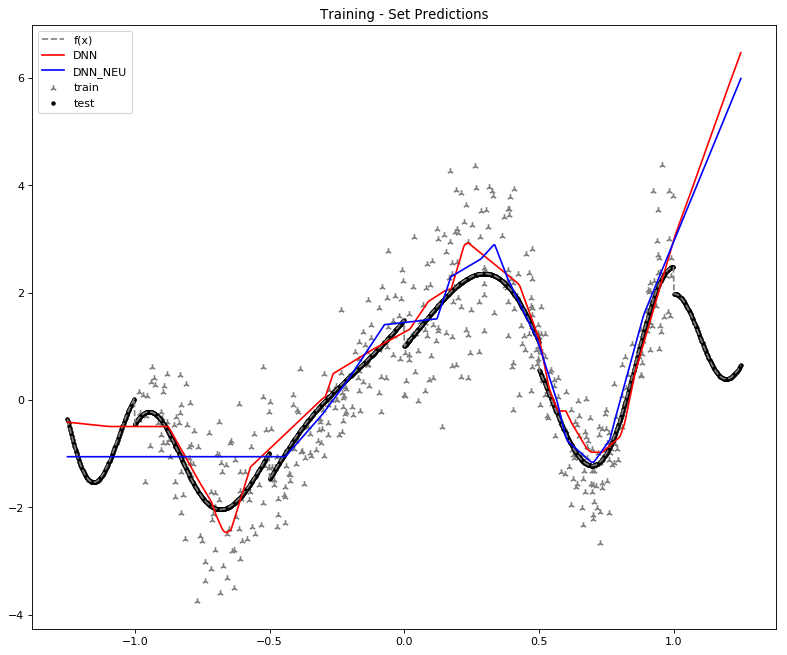

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='DNN')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [8]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if False:#os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
2.0825917665137066
0.02
0.5986892870007356
0.04
4.8275408299960585
0.06
1.2605933576670514
0.08
1.8905081502423127
0.1
4.161424166808625
0.12
1.1495210661335478
0.14
0.6432278218082271
0.16
0.6403114751744056
0.18
0.6760822745046684
0.2
3.946755378713622
0.22
4.642880244829041
0.24
4.550064851369826
0.26
0.8156705298680572
0.28
4.67667772038552
0.3
0.6094348437367094
0.32
4.00293250890484
0.34
4.927842144149619
0.36
2.833964070268682
0.38
3.772532350173961
0.4
2.0134444762786976
0.42
4.435530400888907
0.44
1.7440582095830381
0.46
4.891212212487429
0.48
0.643280266707626
0.5
2.231754651339405
0.52
2.9921291448613463
0.54
1.215428601640158
0.56
3.312266924668271
0.58
3.925219695350534
0.6
1.5241747608080645
0.62
0.5439523743119378
0.64
1.15107875931185
0.66
1.789418473516987
0.68
0.7419243972773878
0.7
0.367112273769705
0.72
4.854845305270578
0.74
3.7663398094540357
0.76
0.6747876236393453
0.78
4.03087362471678
0.8
4.624749907235029
0.82
4.9452

16/16 [==============================] - 1s 40ms/step - loss: 0.6725 - mse: 0.6985 - mae: 0.6441
Epoch 63/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6775 - mse: 0.7054 - mae: 0.6496
Epoch 64/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6779 - mse: 0.6993 - mae: 0.6512
Epoch 65/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6781 - mse: 0.7019 - mae: 0.6499
Epoch 66/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6752 - mse: 0.6940 - mae: 0.6481
Epoch 67/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6725 - mse: 0.7007 - mae: 0.6444
Epoch 68/600
16/16 [==============================] - 1s 39ms/step - loss: 0.6744 - mse: 0.6975 - mae: 0.6463
Epoch 69/600
16/16 [==============================] - 1s 39ms/step - loss: 0.6767 - mse: 0.7024 - mae: 0.6484
Epoch 70/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6743 - mse: 0.6943 - mae: 0.6476
Epoch 71/600
16/16 [===

16/16 [==============================] - 1s 41ms/step - loss: 0.6743 - mse: 0.6934 - mae: 0.6463
Epoch 137/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6812 - mse: 0.7034 - mae: 0.6537
Epoch 138/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6682 - mse: 0.6897 - mae: 0.6400
Epoch 139/600
16/16 [==============================] - 1s 39ms/step - loss: 0.6728 - mse: 0.6936 - mae: 0.6456
Epoch 140/600
16/16 [==============================] - 1s 36ms/step - loss: 0.6751 - mse: 0.6952 - mae: 0.6479
Epoch 141/600
16/16 [==============================] - 1s 36ms/step - loss: 0.6697 - mse: 0.6889 - mae: 0.6422
Epoch 142/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6762 - mse: 0.6949 - mae: 0.6483
Epoch 143/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6736 - mse: 0.6978 - mae: 0.6456
Epoch 144/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6802 - mse: 0.7011 - mae: 0.6528
Epoch 145/600
1

16/16 [==============================] - 1s 41ms/step - loss: 0.6769 - mse: 0.6987 - mae: 0.6492
Epoch 210/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6762 - mse: 0.6908 - mae: 0.6494
Epoch 211/600
16/16 [==============================] - 1s 36ms/step - loss: 0.6764 - mse: 0.6999 - mae: 0.6480
Epoch 212/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6727 - mse: 0.6963 - mae: 0.6447
Epoch 213/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6714 - mse: 0.6894 - mae: 0.6440
Epoch 214/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6722 - mse: 0.7011 - mae: 0.6439
Epoch 215/600
16/16 [==============================] - 1s 39ms/step - loss: 0.6734 - mse: 0.6959 - mae: 0.6461
Epoch 216/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6735 - mse: 0.6939 - mae: 0.6468
Epoch 217/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6733 - mse: 0.7037 - mae: 0.6448
Epoch 218/600
1

16/16 [==============================] - 1s 39ms/step - loss: 0.6724 - mse: 0.6950 - mae: 0.6448
Epoch 283/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6700 - mse: 0.6878 - mae: 0.6425
Epoch 284/600
16/16 [==============================] - 1s 43ms/step - loss: 0.6783 - mse: 0.7031 - mae: 0.6504
Epoch 285/600
16/16 [==============================] - 1s 42ms/step - loss: 0.6715 - mse: 0.6890 - mae: 0.6437
Epoch 286/600
16/16 [==============================] - 1s 43ms/step - loss: 0.6768 - mse: 0.7026 - mae: 0.6487
Epoch 287/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6696 - mse: 0.6847 - mae: 0.6427
Epoch 288/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6779 - mse: 0.6996 - mae: 0.6499
Epoch 289/600
16/16 [==============================] - 1s 45ms/step - loss: 0.6753 - mse: 0.6959 - mae: 0.6477
Epoch 290/600
16/16 [==============================] - 1s 45ms/step - loss: 0.6760 - mse: 0.7006 - mae: 0.6481
Epoch 291/600
1

16/16 [==============================] - 1s 38ms/step - loss: 0.6792 - mse: 0.7031 - mae: 0.6517
Epoch 356/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6741 - mse: 0.6974 - mae: 0.6461
Epoch 357/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6754 - mse: 0.6986 - mae: 0.6478
Epoch 358/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6761 - mse: 0.6958 - mae: 0.6486
Epoch 359/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6734 - mse: 0.6973 - mae: 0.6452
Epoch 360/600
16/16 [==============================] - 1s 42ms/step - loss: 0.6725 - mse: 0.6915 - mae: 0.6447
Epoch 361/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6712 - mse: 0.6904 - mae: 0.6440
Epoch 362/600
16/16 [==============================] - 1s 39ms/step - loss: 0.6775 - mse: 0.6980 - mae: 0.6495
Epoch 363/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6768 - mse: 0.7004 - mae: 0.6491
Epoch 364/600
1

16/16 [==============================] - 1s 59ms/step - loss: 0.6779 - mse: 0.7026 - mae: 0.6497
Epoch 429/600
16/16 [==============================] - 1s 57ms/step - loss: 0.6794 - mse: 0.7057 - mae: 0.6520
Epoch 430/600
16/16 [==============================] - 1s 40ms/step - loss: 0.6699 - mse: 0.6918 - mae: 0.6424
Epoch 431/600
16/16 [==============================] - 1s 39ms/step - loss: 0.6776 - mse: 0.7023 - mae: 0.6499
Epoch 432/600
16/16 [==============================] - 1s 44ms/step - loss: 0.6766 - mse: 0.7002 - mae: 0.6493
Epoch 433/600
16/16 [==============================] - 1s 47ms/step - loss: 0.6677 - mse: 0.6834 - mae: 0.6401
Epoch 434/600
16/16 [==============================] - 1s 42ms/step - loss: 0.6707 - mse: 0.6945 - mae: 0.6425
Epoch 435/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6744 - mse: 0.6997 - mae: 0.6459
Epoch 436/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6788 - mse: 0.7032 - mae: 0.6507
Epoch 437/600
1

16/16 [==============================] - 1s 42ms/step - loss: 0.6780 - mse: 0.7008 - mae: 0.6504
Epoch 502/600
16/16 [==============================] - 1s 41ms/step - loss: 0.6758 - mse: 0.6978 - mae: 0.6482
Epoch 503/600
16/16 [==============================] - 1s 43ms/step - loss: 0.6717 - mse: 0.6897 - mae: 0.6444
Epoch 504/600
16/16 [==============================] - 1s 56ms/step - loss: 0.6723 - mse: 0.6956 - mae: 0.6447
Epoch 505/600
16/16 [==============================] - 1s 60ms/step - loss: 0.6740 - mse: 0.6932 - mae: 0.6472
Epoch 506/600
16/16 [==============================] - 1s 48ms/step - loss: 0.6710 - mse: 0.6904 - mae: 0.6434
Epoch 507/600
16/16 [==============================] - 1s 51ms/step - loss: 0.6763 - mse: 0.7019 - mae: 0.6490
Epoch 508/600
16/16 [==============================] - 1s 48ms/step - loss: 0.6769 - mse: 0.7005 - mae: 0.6486
Epoch 509/600
16/16 [==============================] - 1s 51ms/step - loss: 0.6720 - mse: 0.6944 - mae: 0.6449
Epoch 510/600
1

16/16 [==============================] - 1s 37ms/step - loss: 0.6729 - mse: 0.6941 - mae: 0.6457
Epoch 575/600
16/16 [==============================] - 1s 36ms/step - loss: 0.6744 - mse: 0.6976 - mae: 0.6462
Epoch 576/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6721 - mse: 0.6896 - mae: 0.6451
Epoch 577/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6777 - mse: 0.7044 - mae: 0.6494
Epoch 578/600
16/16 [==============================] - 1s 36ms/step - loss: 0.6779 - mse: 0.7015 - mae: 0.6505
Epoch 579/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6737 - mse: 0.6923 - mae: 0.6460
Epoch 580/600
16/16 [==============================] - 1s 37ms/step - loss: 0.6721 - mse: 0.6880 - mae: 0.6446
Epoch 581/600
16/16 [==============================] - 1s 36ms/step - loss: 0.6756 - mse: 0.6998 - mae: 0.6473
Epoch 582/600
16/16 [==============================] - 1s 38ms/step - loss: 0.6741 - mse: 0.6950 - mae: 0.6472
Epoch 583/600
1

### Generate Plots - Visualization

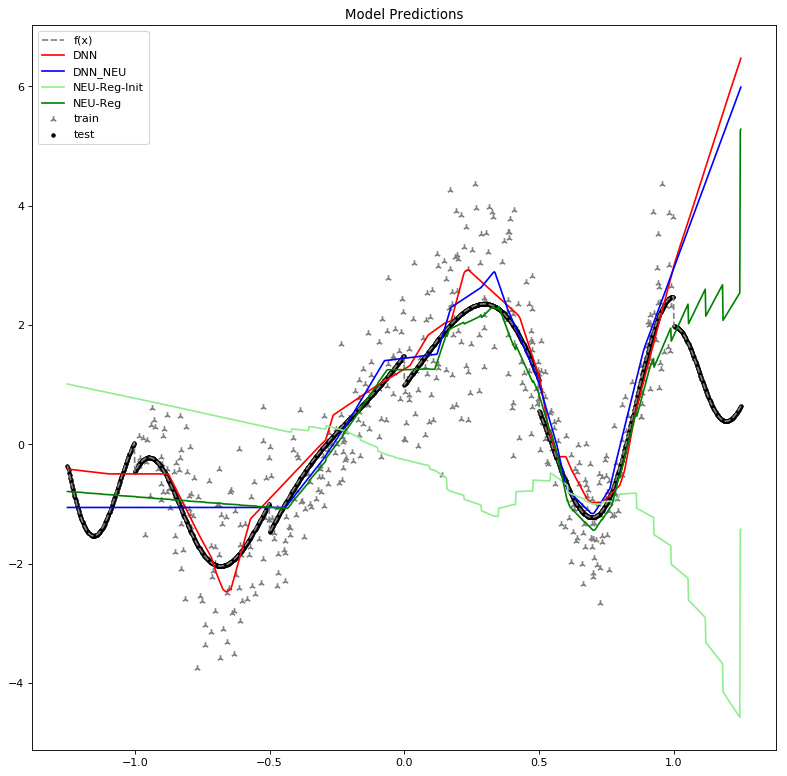

In [9]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

In [10]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Trained model already exists: Loading.
GLd-Nets trained model: Loaded.
Benchmark Model - GLd-Nets: Ready!


In [11]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Trained model already exists: Loading.
Ed-Nets trained model: Loaded.
Benchmark Model - Ed-Nets: Ready!


Run univariate regression benchmarks file:

In [12]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [13]:
# Train Set #
#-----------#
Vanilla = get_results(predictions_OLS_Benchmark,data_y)
NEU = get_results(NEU_OLS_prediction,data_y)
NEU_Gld = get_results(Deep_GLd_prediction,data_y)
NEU_Ed = get_results(Deep_Ed_prediction,data_y)
SSplines = get_results(f_hat_smoothing_splines_train,data_y)
LOESS = get_results(LOESS_prediction_train,data_y)

# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results = pd.DataFrame.transpose(Results)

# Write Results to file #
#-----------------------#
Results.to_latex('./outputs/results/Performance.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results))

Test results.

In [14]:
# Test Set #
#----------#
Vanilla = get_results(predictions_OLS_Benchmark_test,data_y_test)
NEU = get_results(NEU_OLS_prediction_test,data_y_test)
NEU_Gld = get_results(Deep_GLd_prediction_test,data_y_test)
NEU_Ed = get_results(Deep_Ed_prediction_test,data_y_test)
SSplines = get_results(f_hat_smoothing_splines_test,data_y_test)
LOESS = get_results(LOESS_prediction_test,data_y_test)

# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results_test = pd.DataFrame.transpose(Results_test)

# Write Results to file #
#-----------------------#
Results_test.to_latex('./outputs/results/Performance_test.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_test_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results_test))

# Visualize Predictions

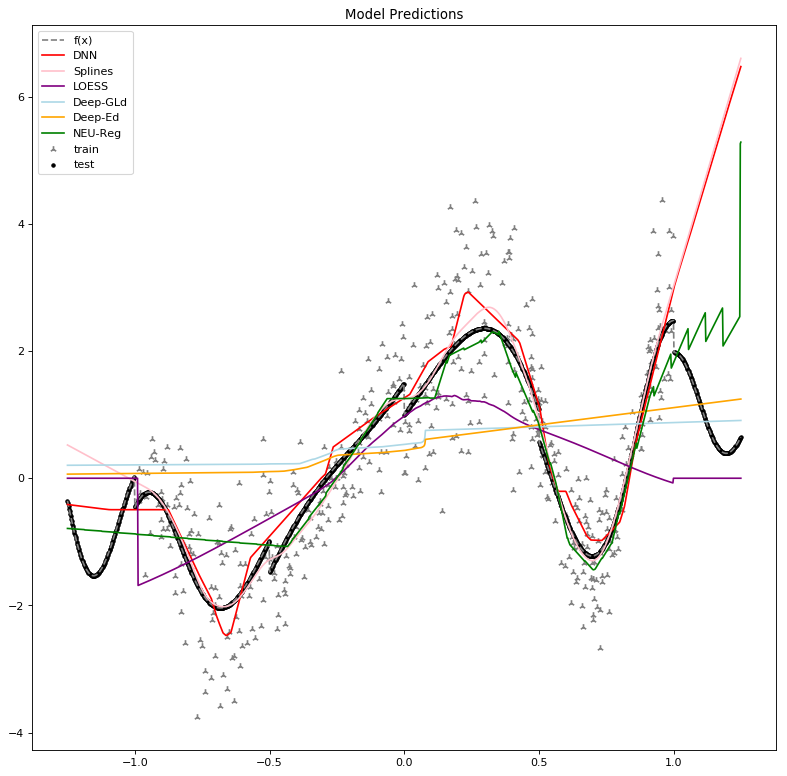

In [15]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
#------------------#
# Standard Benchmarks
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')
# Plot Univariate Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# NEU Benchmarks: Alternatives to reconfigurations
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')

# Plot NEU Regressors
# ---------------------------------- for INDEV  only: BEGIN --------------------------------------------------- #
# plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
# plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
# ---------------------------------- for INDEV  only: END ----------------------------------------------------- #
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

# Report Results

In [16]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Train Results:


,MSE,MAE,MinE,MaxE,rMSE
Vanilla,0.665828,0.003374,2.511983,0.686077,0.678169
NEU,0.662786,0.000964,2.789080,0.748490,0.678582
NEU_GLd,1.273886,0.005072,3.962109,2.450559,1.316079
NEU_Ed,1.259831,0.000290,3.831282,2.427576,1.302654
Smoothing_Splines,0.600748,0.000526,2.393508,0.587719,0.612273
LOESS,1.055897,0.000488,4.386781,1.756673,1.088776


In [17]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

Test Results:


,MSE,MAE,MinE,MaxE,rMSE
Vanilla,0.612177,0.000167,5.827493,1.727982,0.689168
NEU,0.417538,0.000204,4.639446,0.391173,0.428884
NEU_GLd,1.058465,0.000810,2.256197,1.480519,1.076540
NEU_Ed,1.038719,0.002593,2.168656,1.423961,1.056031
Smoothing_Splines,0.596555,0.000104,5.956548,1.889965,0.683368
LOESS,0.816907,0.000760,2.551398,0.963699,0.831915


#### The END

---